In [1]:
from torchvision import datasets, transforms
from torch.utils import data

train_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=True, download=True, # 다운로드 경로
                         transform=transforms.Compose([ # 이미지를 텐서로 바꿔주는 코드
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=128
)

test_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=False, download=True, # 다운로드 경로
                         transform=transforms.Compose([ # 이미지를 텐서로 바꿔주는 코드
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=128
)

# CNN 기본

In [2]:
import torch
import torch.nn as nn

# 합성곱 레이어 객체 생성
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu')) # 입력 채널 수, 출력 채널 수, 커널 사이즈, stride
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [3]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

In [4]:
# 가중치 시각화
weight = weight.detach().numpy()
weight.shape

(20, 1, 5, 5)

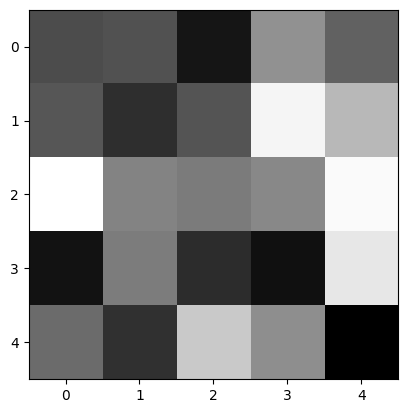

In [5]:
import matplotlib.pyplot as plt

plt.imshow(weight[0, 0, :, :], 'gray')
plt.show()

In [6]:
# 입력 이미지와 출력 이미지 비교를 위해 데이터 불러온 후 layer 통과
images, labels = next(iter(train_loader))

output_data = layer(images)
output_data = output_data.data

output = output_data.cpu().numpy()
output.shape

(128, 20, 24, 24)

In [7]:
images.shape # 5x5 kernel을 통과하여 output이 줄어듬

torch.Size([128, 1, 28, 28])

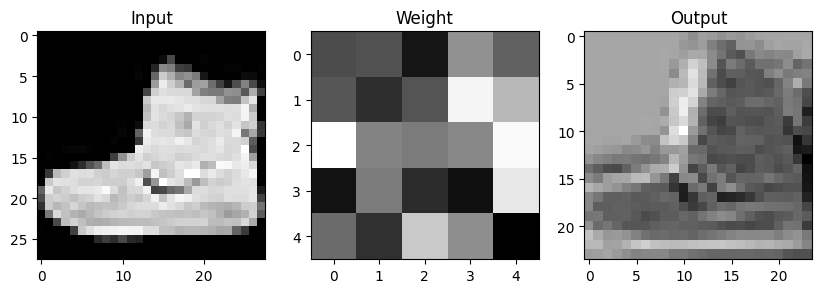

In [8]:
plt.figure(figsize=(10, 20))

# 원본 이미지
plt.subplot(131)
plt.title('Input')
plt.imshow(images[0, 0, :, :], 'gray')

# 필터 이미지
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], 'gray')

# 필터 후 이미지
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0, 0, :, :], 'gray')

plt.show()

In [9]:
# pooling
import torch.nn.functional as f

pool = f.max_pool2d(images, 2, 2) # 커널 사이즈, stride
pool.shape

torch.Size([128, 1, 14, 14])

In [10]:
images.shape # 커널 사이즈 때문에 크기가 반으로 줄어듬

torch.Size([128, 1, 28, 28])

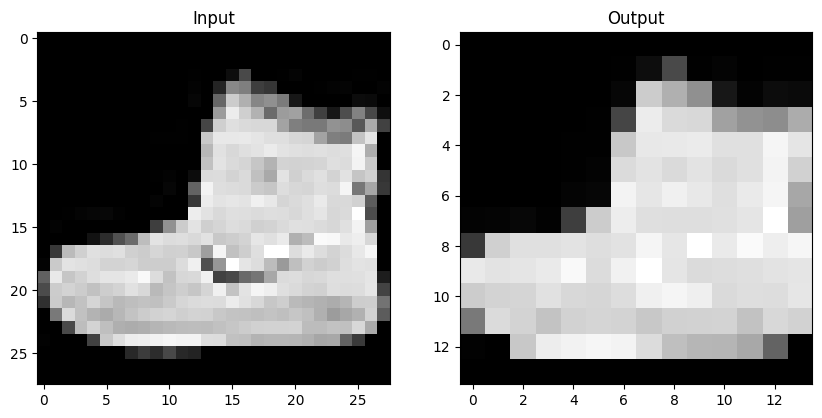

In [11]:
plt.figure(figsize=(10, 15))

# 원본 이미지
plt.subplot(121)
plt.title('Input')
plt.imshow(images[0, 0, :, :], 'gray')

# 풀링 이미지
pool_arr = pool.numpy()

plt.subplot(122)
plt.title('Output')
plt.imshow(pool_arr[0, 0, :, :], 'gray')

plt.show()

# 학습

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [14]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 5) # 입력 채널 수=1, 출력 채널 수=10, 커널 사이즈=5, stride=1(기본값)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.drop = nn.Dropout2d() # 출력값에 Dropout 적용
        
        # input이 320인 이유는 아래 forward의 주석 확인
        self.fc1 = nn.Linear(320, 160) # 선형결합연산을 수행하는 객체
        self.fc2 = nn.Linear(160, 80) # 히든 레이어
        self.fc3 = nn.Linear(80, 10) # 출력 레이어
    
    def forward(self, x):
        # 1x28x28 -> 10x24x24 -> 10x12x12
        x = f.relu(f.max_pool2d(self.conv1(x), 2)) # 합성곱 레이어, 풀링, 활성화 함수 순
        
        # 10x12x12 -> 20x8x8 -> 20x4x4
        x = f.relu(f.max_pool2d(self.drop(self.conv2(x)), 2)) # dropout 추가
        
        # 20x4x4 -> 1x320
        x = x.view(-1, 320) # 평탄화 작업
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.dropout(x, training=self.training)
        x = self.fc3(x)
        return x

In [15]:
model = Cnn().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [16]:
EPOCHS = 30
train_history = []
test_history = []

for epoch in range(1, EPOCHS+1):
    model.train()
    
    # 학습 데이터를 배치 사이즈만큼 반복
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train Epoch: {epoch}\tLoss:{loss.item():.6f}')
    train_history.append(loss.item())
    
    model.eval() # 검증 모드
    
    test_loss = 0 # 테스트 데이터 오차
    correct = 0 # 정답 수
    
    with torch.no_grad(): # 평가 때는 기울기 계산 필요 없음
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += f.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # dim=1: 차원, keepdim=True: 차원 유지
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_history.append(test_loss)
    
    print(f'Test set: Average Loss: {test_loss:.4f}, Accuracy: {correct/len(test_loader.dataset)*100:.0f}%\n')

Train Epoch: 1	Loss:2.250925
Test set: Average Loss: 2.2184, Accuracy: 24%

Train Epoch: 2	Loss:1.357818
Test set: Average Loss: 1.0024, Accuracy: 61%

Train Epoch: 3	Loss:0.890828
Test set: Average Loss: 0.8206, Accuracy: 71%

Train Epoch: 4	Loss:0.802057
Test set: Average Loss: 0.7418, Accuracy: 72%

Train Epoch: 5	Loss:0.855474
Test set: Average Loss: 0.6800, Accuracy: 74%

Train Epoch: 6	Loss:0.704948
Test set: Average Loss: 0.6601, Accuracy: 74%

Train Epoch: 7	Loss:0.660326
Test set: Average Loss: 0.6287, Accuracy: 76%

Train Epoch: 8	Loss:0.707360
Test set: Average Loss: 0.6101, Accuracy: 77%

Train Epoch: 9	Loss:0.615126
Test set: Average Loss: 0.5991, Accuracy: 77%

Train Epoch: 10	Loss:0.641442
Test set: Average Loss: 0.5794, Accuracy: 78%

Train Epoch: 11	Loss:0.620030
Test set: Average Loss: 0.5731, Accuracy: 78%

Train Epoch: 12	Loss:0.654934
Test set: Average Loss: 0.5615, Accuracy: 78%

Train Epoch: 13	Loss:0.591602
Test set: Average Loss: 0.5540, Accuracy: 79%

Train Ep

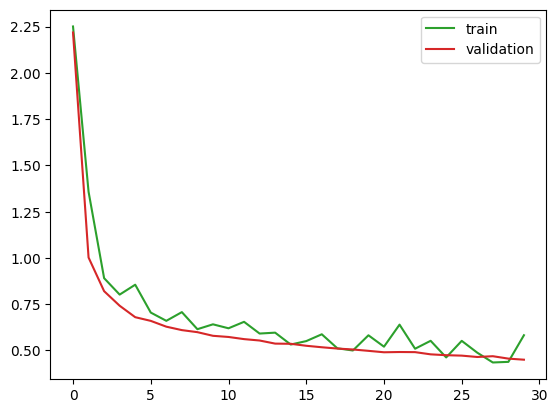

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_history, color='tab:green', label='train')
plt.plot(test_history, color='tab:red', label='validation')
plt.legend()
plt.show()

## 학습 결과 확인

In [18]:
datas, labels = next(iter(test_loader))

pred = model(datas.to(device))

print('Real:', labels[0].item())
print('Pred:', pred[0].argmax().cpu().item())

Real: 9
Pred: 9


In [19]:
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # dim=1: 차원, keepdim=True: 차원 유지

        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        for p, t in zip(pred, target):
            predictions.append(p)
            targets.append(t)

### 혼동 행렬

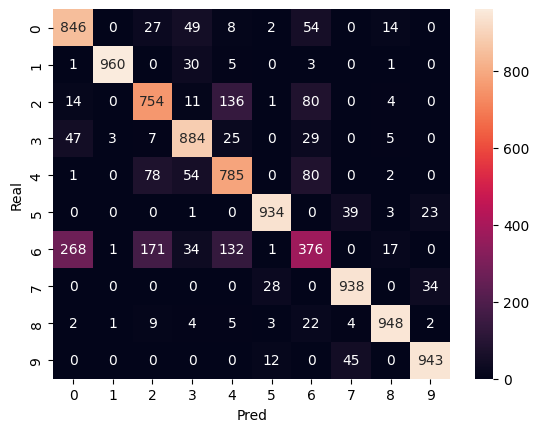

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(targets, predictions), annot=True, fmt='d')
plt.xlabel('Pred')
plt.ylabel('Real')
plt.show()

### 분류 보고서

In [21]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1000
           1       0.99      0.96      0.98      1000
           2       0.72      0.75      0.74      1000
           3       0.83      0.88      0.86      1000
           4       0.72      0.79      0.75      1000
           5       0.95      0.93      0.94      1000
           6       0.58      0.38      0.46      1000
           7       0.91      0.94      0.93      1000
           8       0.95      0.95      0.95      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.83      0.84      0.83     10000

